## DistilBERT Model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# # Install required packages
# !pip install --upgrade transformers datasets
# !pip install --upgrade accelerate

# Verify A100 GPU is available
print("\n" + "="*60)
print("GPU CHECK")
print("="*60)
!nvidia-smi
print("\n" + "="*60)


GPU CHECK
Mon Dec  1 05:19:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------------------------------

In [5]:
# Importing libraries and packages

In [6]:
import pandas as pd
import torch
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [7]:
# Loading the data
filename = '/content/drive/MyDrive/NLP/complaints.csv'
try:
    df = pd.read_csv(filename)
    print(f"Successfully loaded {len(df)} rows from {filename}.")
except FileNotFoundError:
    print(f"ERROR: File '{filename}' not found.")
    raise

print(f"Successfully loaded {len(df)} rows from the local CSV.")
print("DataFrame is ready. Here are the columns:")
print(df.columns.tolist())

Successfully loaded 12218152 rows from /content/drive/MyDrive/NLP/complaints.csv.
Successfully loaded 12218152 rows from the local CSV.
DataFrame is ready. Here are the columns:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


## Loading and Preprocessing the data

Importing packages

In [8]:
# Defining columns
feature_column = 'Consumer complaint narrative'
label_column = 'Product'

In [9]:
# Dropping rows where the narrative is missing
df.dropna(subset=[feature_column], inplace=True)
print(f"Rows remaining after dropping missing narratives: {len(df)}")


Rows remaining after dropping missing narratives: 3537241


In [10]:

# Merge Duplicate Categories
print("Cleaning and merging duplicate categories...")
credit_categories = [
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Credit reporting or other personal consumer reports',
    'Credit reporting'
]
clean_name = 'Credit Reporting'
df[label_column] = df[label_column].replace(credit_categories, clean_name)
print("Category merging complete.")


Cleaning and merging duplicate categories...
Category merging complete.


In [11]:

# Define X and y
X = df[feature_column]
y = df[label_column]

In [12]:
# Remove Rare Classes (n < 2)
print("Removing rare classes...")
class_counts = y.value_counts()
rare_classes = class_counts[class_counts < 2].index.tolist()
if len(rare_classes) > 0:
    keep_indices = y.isin(rare_classes) == False
    X_filtered = X[keep_indices]
    y_filtered = y[keep_indices]
else:
    X_filtered = X
    y_filtered = y
print(f"Filtered data size: {len(y_filtered)}")

Removing rare classes...
Filtered data size: 3537241


In [13]:
# Creating Label Dictionaries ---
print("Creating label dictionaries...")
labels = sorted(y_filtered.unique())
num_labels = len(labels)
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}

Creating label dictionaries...


In [14]:
# Creating final DataFrame
df_final = pd.DataFrame({
    'text': X_filtered,
    'label': y_filtered.map(label_to_id) # Map string labels to int labels
})
print(f"Data is ready. Number of labels: {num_labels}")

Data is ready. Number of labels: 19


In [15]:
# Split the data
train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    stratify=df_final['label'],
    random_state=42
)

In [16]:
# Converting to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

Training set size: 2829792, Validation set size: 707449


In [17]:
# Tokenizing the data
print("Loading tokenizer...")
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512
    )

Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [18]:
print("Tokenizing training data...")
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
print("Tokenizing validation data...")
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

Tokenizing training data...


Map:   0%|          | 0/2829792 [00:00<?, ? examples/s]

Tokenizing validation data...


Map:   0%|          | 0/707449 [00:00<?, ? examples/s]

In [19]:
# Cleaning up datasets for model
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['text', '__index_level_0__'])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(['text', '__index_level_0__'])
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_val_dataset = tokenized_val_dataset.rename_column("label", "labels")
tokenized_train_dataset.set_format('torch')
tokenized_val_dataset.set_format('torch')

In [20]:
# Load Model
print("Loading pre-trained DistilBERT model...")
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)

Loading pre-trained DistilBERT model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Check for GPU and display memory info
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model moved to: {device}")

if torch.cuda.is_available():
    print(f"\nGPU Details:")
    print(f"  - Device: {torch.cuda.get_device_name(0)}")
    print(f"  - Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  - CUDA Version: {torch.version.cuda}")
    print(f"  - PyTorch Version: {torch.__version__}")

    # Check if A100 is allocated
    gpu_name = torch.cuda.get_device_name(0)
    if "A100" in gpu_name:
        print(f"\n✓ SUCCESS: A100 GPU detected!")
        print(f"  You can use batch_size up to 64 safely.")
    else:
        print(f"\n⚠ WARNING: Not an A100 GPU!")
        print(f"  Consider switching runtime to A100 for faster training.")
else:
    print("\n⚠ ERROR: No GPU detected! Please change runtime type to GPU.")

Model moved to: cuda

GPU Details:
  - Device: NVIDIA A100-SXM4-40GB
  - Total Memory: 42.47 GB
  - CUDA Version: 12.6
  - PyTorch Version: 2.9.0+cu126

✓ SUCCESS: A100 GPU detected!
  You can use batch_size up to 64 safely.


In [22]:
# Defining Metrics Function
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    macro_f1 = f1_score(labels, preds, average='macro') #
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'macro_f1': macro_f1}


In [23]:
# Training Arguments - OPTIMIZED FOR A100 GPU
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,

    # A100 OPTIMIZATIONS:
    per_device_train_batch_size=32,      # Increased from 16 (A100 has 40GB memory)
    per_device_eval_batch_size=32,       # Increased from 16
    fp16=False,                          # Disable fp16 for A100
    bf16=True,                           # Enable bfloat16 (A100 native support - FASTER!)

    # Training settings
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,                  # Explicitly set learning rate

    # Logging and evaluation
    logging_dir='./logs',
    logging_steps=50,                    # More frequent logging
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",

    # Performance
    dataloader_num_workers=2,            # Faster data loading
    gradient_accumulation_steps=1,       # Can increase if OOM

    # Disable wandb/tensorboard
    report_to="none",
)

print("Training Arguments configured for A100 GPU:")
print(f"  - Batch size: {training_args.per_device_train_batch_size}")
print(f"  - BFloat16: {training_args.bf16}")
print(f"  - Total training steps: ~{len(tokenized_train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

print("\nTrainer initialized successfully!")

Training Arguments configured for A100 GPU:
  - Batch size: 32
  - BFloat16: True
  - Total training steps: ~265293

Trainer initialized successfully!


In [24]:
# START TRAINING
print("\n" + "="*60)
print("STARTING MODEL FINE-TUNING")
print("="*60)
print(f"Training on {len(tokenized_train_dataset)} samples")
print(f"Validating on {len(tokenized_val_dataset)} samples")
print("="*60 + "\n")

# Start training
import time
start_time = time.time()

trainer.train()

end_time = time.time()
training_duration = end_time - start_time

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Total training time: {training_duration/60:.2f} minutes")

# Show GPU memory usage
if torch.cuda.is_available():
    print(f"Peak GPU memory used: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")
    print(f"Current GPU memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print("="*60)


STARTING MODEL FINE-TUNING
Training on 2829792 samples
Validating on 707449 samples



Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.286600,0.291110,0.901510,0.574959
2,0.254500,0.274818,0.908755,0.592838
3,0.218500,0.276425,0.910416,0.604098



TRAINING COMPLETE
Total training time: 277.65 minutes
Peak GPU memory used: 4.45 GB
Current GPU memory used: 0.83 GB


In [25]:
# Final Evaluation
print("\nRunning final evaluation on the validation set:")
eval_results = trainer.evaluate()

print("\n--- FINAL MODEL RESULTS ---")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Macro F1-Score: {eval_results['eval_macro_f1']:.4f}")


Running final evaluation on the validation set:



--- FINAL MODEL RESULTS ---
Accuracy: 0.9104
Macro F1-Score: 0.6041


Generating Transformer Confusion Matrix

Saved 'distilbert_confusion_matrix.png'


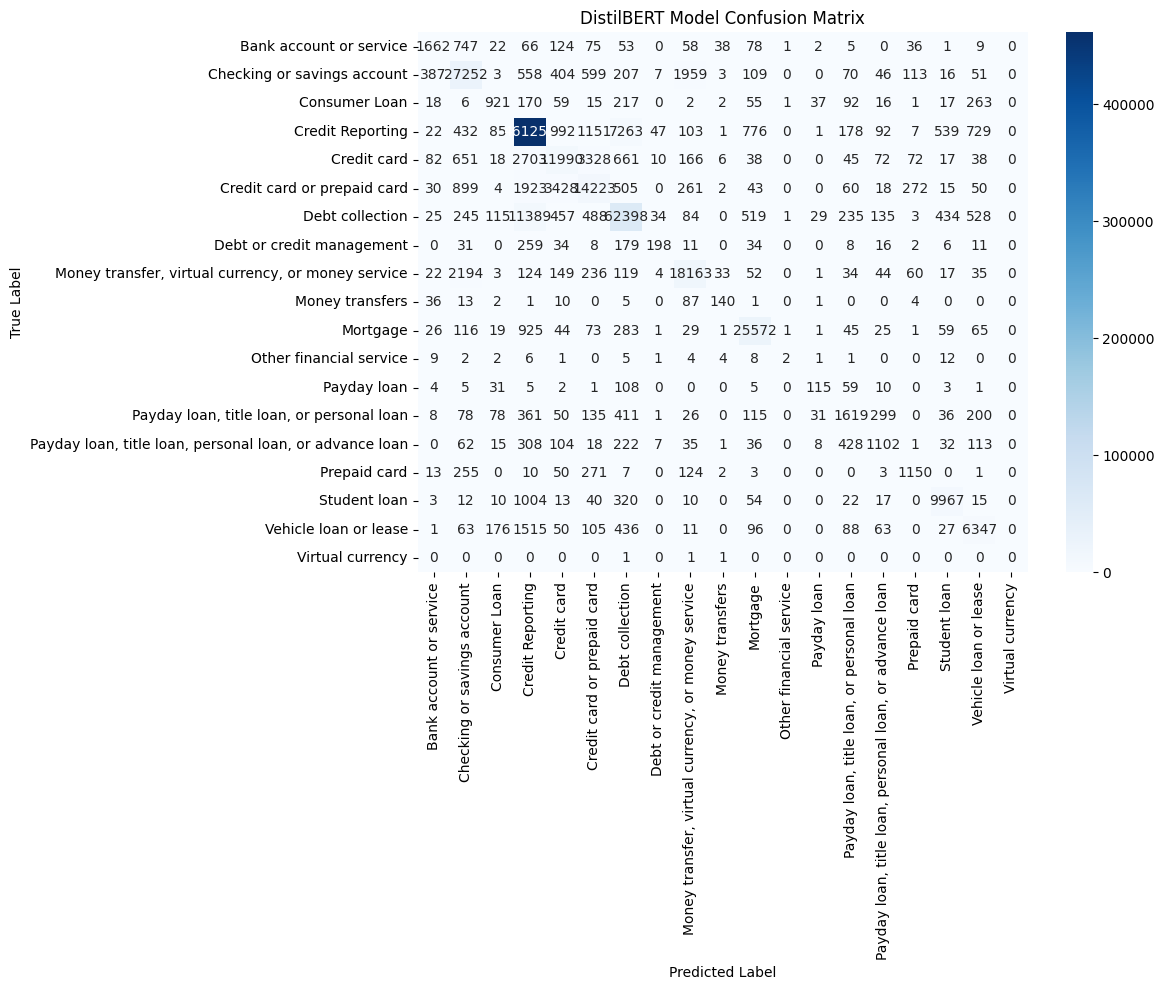

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred_output = trainer.predict(tokenized_val_dataset)

y_preds = np.argmax(pred_output.predictions, axis=1)

y_true = pred_output.label_ids

class_names = labels

cm = confusion_matrix(y_true, y_preds, labels=range(len(class_names)))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',     # Format as integers
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('DistilBERT Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

plt.savefig('distilbert_confusion_matrix.png')
print("Saved 'distilbert_confusion_matrix.png'")
plt.show()